<a href="https://colab.research.google.com/github/gnanadeepakvardhan/karkhana-assignment/blob/main/KarkhanaAssignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Enter Radius(Ex: 10): 10
Enter Width(Ex: 3): 3
Enter Resolution(Ex: 80): 80
Möbius Strip Animator - Classic Edition
Constructing Mobius Strip: R=10, w=3, res=80x80...
Mobius properties computed. Animation module standing by.

--- Strip Geometric Data ---
Config: Radius (R): 10
Config: Width (w): 3
Config: Resolution (n x n): 80x80
Computed: Approx. Surface Area: 188.548
Computed: Approx. Edge Length: 125.988

Preparing Classic Animation...

Saving Classic Animated Mobius Strip to: mobius_strip_classic_animated.gif
This may take a moment...
Animation saved successfully: mobius_strip_classic_animated.gif
Showing animation. Close the plot window to exit.


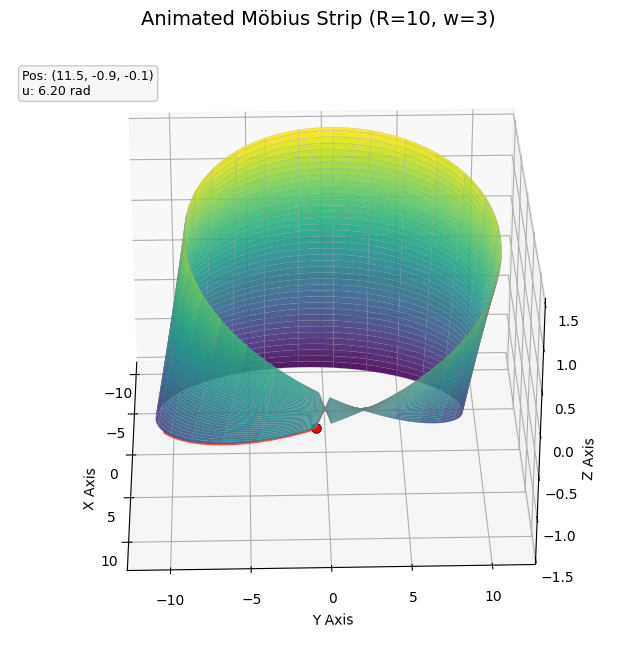


Animation process complete.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import FuncAnimation, PillowWriter
from pathlib import Path

# Configuration
RADIUS = int(input("Enter Radius(Ex: 10): "))        # R: Increased for a BIGGER strip
WIDTH = int(input("Enter Width(Ex: 3): "))          # w: Proportional width
RESOLUTION = int(input("Enter Resolution(Ex: 80): "))       # n: Mesh resolution (n x n)

# Animation specific settings
ANIMATION_FRAMES = 240   # Total frames for one full loop
ANIMATION_INTERVAL = 40  # Milliseconds between frames (25 fps)
PARTICLE_TRAIL_LENGTH = 15 # Length of the simple particle trail

OUTPUT_FILENAME_ANIMATION = "mobius_strip_classic_animated.gif"

class MobiusStrip:
    def __init__(self, R, w, n_resolution):
        if R <= w/2:
            print(f"FYI: Radius R ({R}) should ideally be > half-width w/2 ({w/2}) "
                  "to avoid central pinching. It'll still be a Mobius strip.")
        self.R = R
        self.w = w
        self.n_res = n_resolution

        self.u_edge_params = np.linspace(0, 2 * np.pi, self.n_res, endpoint=False)

        self.X, self.Y, self.Z = (None, None, None)
        self.surface_area = None
        self.edge_length = None
        self.edge_path_points = None
        self.edge_path_u_values = None

        print(f"Constructing Mobius Strip: R={R}, w={w}, res={n_resolution}x{n_resolution}...")
        self._generate_mesh()
        self._compute_surface_area()
        self._compute_edge_properties()
        print("Mobius properties computed. Animation module standing by.")

    def _parametric_equations(self, u, v):
        x = (self.R + v * np.cos(u / 2)) * np.cos(u)
        y = (self.R + v * np.cos(u / 2)) * np.sin(u)
        z = v * np.sin(u / 2)
        return x, y, z

    def _generate_mesh(self):
        u_mesh_params = np.linspace(0, 2*np.pi, self.n_res, endpoint=False)
        v_mesh_params = np.linspace(-self.w / 2, self.w / 2, self.n_res)

        U_grid, V_grid = np.meshgrid(u_mesh_params, v_mesh_params)
        self.X, self.Y, self.Z = self._parametric_equations(U_grid, V_grid)

        self.X = np.concatenate((self.X, self.X[:,0:1]), axis=1)
        self.Y = np.concatenate((self.Y, self.Y[:,0:1]), axis=1)
        self.Z = np.concatenate((self.Z, self.Z[:,0:1]), axis=1)

    def _compute_surface_area(self):
        area = 0.0
        for i in range(self.n_res - 1):
            for j in range(self.n_res):
                P00 = np.array([self.X[i, j],   self.Y[i, j],   self.Z[i, j]])
                P10 = np.array([self.X[i, j+1], self.Y[i, j+1], self.Z[i, j+1]])
                P01 = np.array([self.X[i+1, j], self.Y[i+1, j], self.Z[i+1, j]])
                P11 = np.array([self.X[i+1,j+1],self.Y[i+1,j+1],self.Z[i+1,j+1]])

                vec1_A = P10 - P00; vec1_B = P01 - P00
                area += 0.5 * np.linalg.norm(np.cross(vec1_A, vec1_B))
                vec2_A = P01 - P11; vec2_B = P10 - P11
                area += 0.5 * np.linalg.norm(np.cross(vec2_A, vec2_B))
        self.surface_area = area

    def _compute_edge_properties(self):
        x_plus, y_plus, z_plus = self._parametric_equations(self.u_edge_params, self.w / 2)
        edge_points_v_plus = np.stack((x_plus, y_plus, z_plus), axis=-1)
        x_minus, y_minus, z_minus = self._parametric_equations(self.u_edge_params, -self.w / 2)
        edge_points_v_minus = np.stack((x_minus, y_minus, z_minus), axis=-1)

        self.edge_path_points = np.vstack((edge_points_v_plus, edge_points_v_minus))
        self.edge_path_u_values = np.concatenate((self.u_edge_params, self.u_edge_params))

        segment_vectors = np.diff(self.edge_path_points, axis=0, append=self.edge_path_points[0:1,:])
        self.edge_length = np.sum(np.linalg.norm(segment_vectors, axis=1))

    def get_properties(self):
        return {
            "Config: Radius (R)": self.R, "Config: Width (w)": self.w,
            "Config: Resolution (n x n)": f"{self.n_res}x{self.n_res}",
            "Computed: Approx. Surface Area": f"{self.surface_area:.3f}",
            "Computed: Approx. Edge Length": f"{self.edge_length:.3f}"
        }

    def animate_strip_classic_theme(self, save_path_gif=None, frames=ANIMATION_FRAMES, interval=ANIMATION_INTERVAL):
        if self.X is None or self.edge_path_points is None:
            print("Cannot animate: Mesh or edge path not generated.")
            return

        fig = plt.figure(figsize=(10, 8)) # Standard figure size
        ax = fig.add_subplot(111, projection='3d')
        # fig.patch.set_facecolor('white') # Default
        # ax.set_facecolor('white') # Default

        # Surface plot - light theme
        surface_plot = ax.plot_surface(self.X, self.Y, self.Z, rstride=2, cstride=3, # Adjust strides for clarity
                                       cmap='viridis', # A good light-theme colormap
                                       edgecolor='grey', linewidth=0.1, alpha=0.9)

        # Particle and simple trail
        particle_color = 'red' # Clearly visible on viridis
        particle_dot, = ax.plot([], [], [], 'o', markersize=7, color=particle_color, markeredgecolor='black', mew=0.5)
        particle_trail, = ax.plot([], [], [], '-', linewidth=2, color=particle_color, alpha=0.7)

        # Line for the fully traversed path (optional, can be distracting in simple theme)
        # traversed_path_line, = ax.plot([], [], [], '-', linewidth=1, color='blue', alpha=0.4)

        # Coordinate and u-value text display - styled for light theme
        coord_text = ax.text2D(0.02, 0.90, "", transform=ax.transAxes, color='black', fontsize=9,
                               bbox=dict(boxstyle="round,pad=0.3", fc="whitesmoke", ec="silver", lw=1, alpha=0.8))

        # Title
        ax.set_title(f"Animated Möbius Strip (R={self.R}, w={self.w})", fontsize=14)

        # Axes labels and limits - standard and visible
        ax.set_xlabel("X Axis")
        ax.set_ylabel("Y Axis")
        ax.set_zlabel("Z Axis")

        # Auto-scaling for limits initially, then fix them for animation stability
        ax.plot(self.edge_path_points[:,0], self.edge_path_points[:,1], self.edge_path_points[:,2], alpha=0) # Invisible plot to set limits
        xlims = ax.get_xlim()
        ylims = ax.get_ylim()
        zlims = ax.get_zlim()
        ax.set_xlim(xlims)
        ax.set_ylim(ylims)
        ax.set_zlim(zlims)

        ax.grid(True, linestyle=':', alpha=0.5) # Standard grid

        num_total_edge_points = self.edge_path_points.shape[0]
        # drawn_path_coords_x, drawn_path_coords_y, drawn_path_coords_z = [], [], [] # If using traversed_path_line
        # last_drawn_point_idx = -1 # If using traversed_path_line

        def update_animation(frame_num):
            # nonlocal last_drawn_point_idx # If using traversed_path_line

            # Camera rotation
            azim_angle = (frame_num * 360 / frames) % 360
            elev_angle = 30 + 10 * np.sin(np.radians(frame_num * 360 / frames * 0.5)) # Gentle bob
            ax.view_init(elev=elev_angle, azim=azim_angle)

            # Particle position
            particle_current_idx = int((frame_num / frames) * num_total_edge_points) % num_total_edge_points
            current_pos = self.edge_path_points[particle_current_idx]
            current_u_val = self.edge_path_u_values[particle_current_idx]

            particle_dot.set_data([current_pos[0]], [current_pos[1]])
            particle_dot.set_3d_properties([current_pos[2]])

            # Simple trail update
            trail_start_idx = particle_current_idx - PARTICLE_TRAIL_LENGTH + 1
            trail_indices = np.arange(max(0, trail_start_idx), particle_current_idx + 1)
            # Handle wrap-around for trail continuity (more advanced, for simplicity we might skip full wrap here)
            # For a simple trail that just cuts off at the start of the path:
            if particle_current_idx < PARTICLE_TRAIL_LENGTH:
                 valid_trail_points = self.edge_path_points[0 : particle_current_idx + 1]
            else:
                 valid_trail_points = self.edge_path_points[trail_start_idx : particle_current_idx + 1]

            if valid_trail_points.shape[0] > 1:
                particle_trail.set_data(valid_trail_points[:,0], valid_trail_points[:,1])
                particle_trail.set_3d_properties(valid_trail_points[:,2])
            else:
                particle_trail.set_data([],[]); particle_trail.set_3d_properties([])

            # Update coordinate text
            coord_str = (f"Pos: ({current_pos[0]:.1f}, {current_pos[1]:.1f}, {current_pos[2]:.1f})\n"
                         f"u: {current_u_val:.2f} rad")
            coord_text.set_text(coord_str)

            # Artists to return for blitting (if blit=True)
            # return_artists = [particle_dot, particle_trail, coord_text]
            # if 'traversed_path_line' in locals(): return_artists.append(traversed_path_line)
            # return return_artists
            return particle_dot, particle_trail, coord_text, # Add other artists if re-enabled

        anim = FuncAnimation(fig, update_animation, frames=frames,
                             interval=interval, blit=False) # blit=False often more stable

        if save_path_gif:
            gif_path = Path(save_path_gif)
            print(f"\nSaving Classic Animated Mobius Strip to: {gif_path}")
            print("This may take a moment...")
            try:
                writer = PillowWriter(fps=int(1000/interval))
                anim.save(gif_path, writer=writer, dpi=90) # DPI for GIF
                print(f"Animation saved successfully: {gif_path}")
            except Exception as e:
                print(f"Error saving GIF: {e}")
                print("Pillow (for GIF) or FFmpeg (for MP4) might be needed, or try a different writer.")

        print("Showing animation. Close the plot window to exit.")
        plt.show()

# --- Main Execution ---
if __name__ == "__main__":
    print("Möbius Strip Animator - Classic Edition")

    # Create a bigger Mobius strip
    mobius_big_classic = MobiusStrip(R=RADIUS, w=WIDTH, n_resolution=RESOLUTION)

    print("\n--- Strip Geometric Data ---")
    for key, val in mobius_big_classic.get_properties().items(): print(f"{key}: {val}")

    print("\nPreparing Classic Animation...")
    mobius_big_classic.animate_strip_classic_theme(save_path_gif=OUTPUT_FILENAME_ANIMATION)

    print("\nAnimation process complete.")